In [1]:
!pip install matplotlib numpy torchvision tqdm


[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip



=== Training Task 1 ===


100%|██████████| 528/528 [00:01<00:00, 503.09it/s]


Epoch 1, Loss: 0.4639


100%|██████████| 528/528 [00:01<00:00, 495.71it/s]


Epoch 2, Loss: 0.1920
Accuracy on Task 1: 0.999

=== Training Task 2 ===


100%|██████████| 504/504 [00:11<00:00, 45.50it/s]


Epoch 1, Loss: 0.7458


100%|██████████| 504/504 [00:11<00:00, 44.15it/s]


Epoch 2, Loss: 0.6556
Accuracy on Task 1: 0.999
Accuracy on Task 2: 0.665

=== Training Task 3 ===


100%|██████████| 470/470 [00:17<00:00, 26.14it/s]


Epoch 1, Loss: 0.7507


100%|██████████| 470/470 [00:17<00:00, 26.66it/s]


Epoch 2, Loss: 0.7191
Accuracy on Task 1: 0.999
Accuracy on Task 2: 0.670
Accuracy on Task 3: 0.537

=== Training Task 4 ===


100%|██████████| 508/508 [00:28<00:00, 18.11it/s]


Epoch 1, Loss: 0.6682


100%|██████████| 508/508 [00:27<00:00, 18.50it/s]


Epoch 2, Loss: 0.6004
Accuracy on Task 1: 0.999
Accuracy on Task 2: 0.671
Accuracy on Task 3: 0.538
Accuracy on Task 4: 0.760

=== Training Task 5 ===


100%|██████████| 492/492 [00:35<00:00, 13.72it/s]


Epoch 1, Loss: 0.8340


100%|██████████| 492/492 [00:35<00:00, 13.80it/s]


Epoch 2, Loss: 0.8107
Accuracy on Task 1: 0.999
Accuracy on Task 2: 0.666
Accuracy on Task 3: 0.523
Accuracy on Task 4: 0.763
Accuracy on Task 5: 0.439
=== Continual Learning Metrics ===
Average Accuracy (ACC):       0.6778
Forgetting (F):              0.0046
Backward Transfer (BWT):     -0.0025
Forward Transfer (FWT):      0.0000
Memory Usage:                1922.94 MB
Computation Cost:            2502 projections/batch
Plasticity-Stability Measure (PSM): 0.4977 (0-1 normalized)
=== Metrics (Split MNIST) ===
ACC=0.6778, F=0.0046, BWT=-0.0025, FWT=0.0000, Mem=1922.94MB, PSM=0.4977


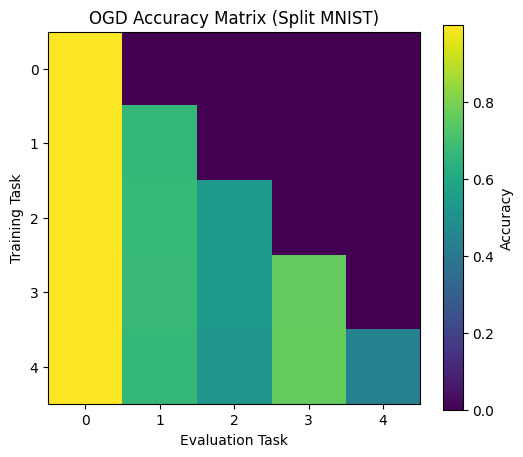

In [2]:
# Orthogonal Gradient Descent (OGD) for Continual Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, output_size=2):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.net(x.view(x.size(0), -1))


# OGD Implementation
class OGD:
    def __init__(self, model, lr=0.001, device='cuda'):
        self.model = model.to(device)
        self.lr = lr
        self.device = device
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.S = []  # Memory of gradient directions from previous tasks

    def _flatten_grad(self):
        return torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])

    def _assign_grad(self, flat_grad):
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.numel()
                p.grad.copy_(flat_grad[idx: idx+numel].view_as(p))
                idx += numel

    def _project_grad(self, g):
        if len(self.S) == 0:
            return g
        g_proj = g.clone()
        for v in self.S:
            proj = (torch.dot(g_proj, v) / torch.dot(v, v)) * v
            g_proj -= proj
        return g_proj

    def observe(self, x, y, criterion=nn.CrossEntropyLoss()):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        out = self.model(x)
        loss = criterion(out, y)
        loss.backward()

        g = self._flatten_grad()
        g_orth = self._project_grad(g)
        self._assign_grad(g_orth)
        self.optimizer.step()
        return loss.item()

    def end_task(self, dataloader, criterion=nn.CrossEntropyLoss()):
        self.model.eval()
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.model.zero_grad()
            out = self.model(x)
            loss = criterion(out, y)
            loss.backward()

            u = self._flatten_grad()
            u_proj = self._project_grad(u)
            norm_u_proj = u_proj / (u_proj.norm() + 1e-10)
            self.S.append(norm_u_proj.detach().clone())


# Prepare Split MNIST (5 tasks, 2 classes each)
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def split_dataset(dataset, classes):
    idx = np.isin(dataset.targets.numpy(), classes)
    data = dataset.data[idx].float()/255.0
    targets = dataset.targets[idx]
    mapping = {cls:i for i,cls in enumerate(classes)}
    targets = torch.tensor([mapping[t.item()] for t in targets])
    return TensorDataset(data.view(-1, 28*28), targets)

task_classes = [[0,1],[2,3],[4,5],[6,7],[8,9]]
train_tasks = [split_dataset(mnist_train, c) for c in task_classes]
test_tasks = [split_dataset(mnist_test, c) for c in task_classes]

# Training with Metrics
num_tasks = len(train_tasks)
num_epochs = 2
batch_size = 32

model = SimpleMLP(input_size=784, hidden_size=256, output_size=2)
ogd = OGD(model, lr=0.001, device=device)

accuracy_matrix = np.zeros((num_tasks, num_tasks))

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            loss = ogd.observe(x, y)
            epoch_loss += loss
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Evaluate on all tasks seen so far
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False)
        acc = evaluate_task(ogd.model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

    # End of task: store gradient directions
    ogd.end_task(train_loader)


# Compute Continual Learning Metrics
# Average Accuracy (ACC)
ACC = accuracy_matrix[-1].mean()  # Final row averaged across tasks

# Average Forgetting (F)
F = np.mean([
    np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j]
    for j in range(num_tasks-1)
])

# Backward Transfer (BWT)
BWT = np.mean([
    accuracy_matrix[-1, j] - accuracy_matrix[j, j]
    for j in range(num_tasks-1)
])

# Forward Transfer (FWT)
# Measures how much previous tasks helped the next task before it was trained
FWT = np.mean([
    accuracy_matrix[i, i+1]
    for i in range(num_tasks-1)
])

# Memory Usage (in MB)
num_params = sum(p.numel() for p in ogd.model.parameters())
mem_usage = len(ogd.S) * num_params * 4 / (1024**2)  # 4 bytes per float32

# 6. Computation Cost (Number of gradient projections per batch)
comp_cost = len(ogd.S)

# Plasticity-Stability Measure (PSM) - Normalized 0 to 1

# Define components
stability = 1 - F                 # High if forgetting is low
plasticity = max(FWT, 0)          # High if positive forward transfer

alpha = 0.5                       # Balance between stability and plasticity
PSM = alpha * stability + (1 - alpha) * plasticity

# Print Metrics
print("=== Continual Learning Metrics ===")
print(f"Average Accuracy (ACC):       {ACC:.4f}")
print(f"Forgetting (F):              {F:.4f}")
print(f"Backward Transfer (BWT):     {BWT:.4f}")
print(f"Forward Transfer (FWT):      {FWT:.4f}")
print(f"Memory Usage:                {mem_usage:.2f} MB")
print(f"Computation Cost:            {comp_cost} projections/batch")
print(f"Plasticity-Stability Measure (PSM): {PSM:.4f} (0-1 normalized)")

print("=== Metrics (Split MNIST) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('OGD Accuracy Matrix (Split MNIST)')
plt.show()


=== Training Task 1 ===


100%|██████████| 1875/1875 [00:03<00:00, 553.25it/s]


Epoch 1, Loss: 2.1086


100%|██████████| 1875/1875 [00:03<00:00, 546.14it/s]


Epoch 2, Loss: 1.5333
Accuracy on Task 1: 0.789

=== Training Task 2 ===


100%|██████████| 1875/1875 [02:45<00:00, 11.35it/s]


Epoch 1, Loss: 1.8762


100%|██████████| 1875/1875 [02:47<00:00, 11.16it/s]


Epoch 2, Loss: 1.2615
Accuracy on Task 1: 0.785
Accuracy on Task 2: 0.798

=== Training Task 3 ===


100%|██████████| 1875/1875 [05:31<00:00,  5.65it/s]


Epoch 1, Loss: 1.7933


100%|██████████| 1875/1875 [05:36<00:00,  5.57it/s]


Epoch 2, Loss: 1.1961
Accuracy on Task 1: 0.785
Accuracy on Task 2: 0.796
Accuracy on Task 3: 0.794
=== Continual Learning Metrics ===
Average Accuracy (ACC):       0.7917
Forgetting (F):              0.0032
Backward Transfer (BWT):     -0.0032
Forward Transfer (FWT):      0.0000
Memory Usage:                4367.28 MB
Computation Cost:            5625 projections/batch
Plasticity-Stability Measure (PSM): 0.4984 (0-1 normalized)
=== Metrics (Permuted MNIST) ===
ACC=0.7917, F=0.0032, BWT=-0.0032, FWT=0.0000, Mem=4367.28MB, PSM=0.4984


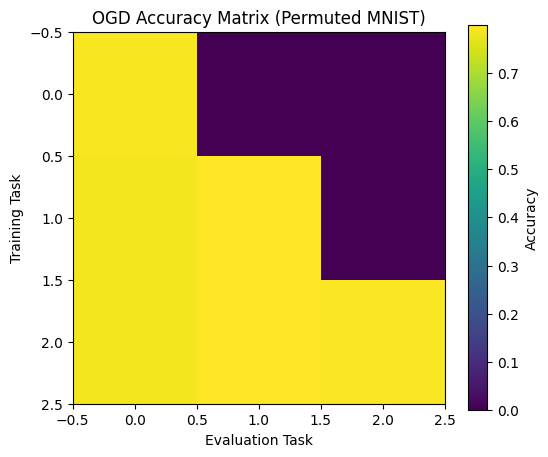

In [3]:
# =======================
# OGD on Permuted MNIST
# =======================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, output_size=10):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, x):
        return self.net(x.view(x.size(0), -1))

# OGD Implementation
class OGD:
    def __init__(self, model, lr=0.001, device='cuda'):
        self.model = model.to(device)
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.device = device
        self.S = []  # Memory of gradient directions

    def _flatten_grad(self):
        return torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])

    def _assign_grad(self, flat_grad):
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.numel()
                p.grad.copy_(flat_grad[idx: idx+numel].view_as(p))
                idx += numel

    def _project_grad(self, g):
        if len(self.S) == 0: return g
        g_proj = g.clone()
        for v in self.S:
            proj = (torch.dot(g_proj, v) / torch.dot(v, v)) * v
            g_proj -= proj
        return g_proj

    def observe(self, x, y, criterion=nn.CrossEntropyLoss()):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        loss = criterion(self.model(x), y)
        loss.backward()

        g = self._flatten_grad()
        g_orth = self._project_grad(g)
        self._assign_grad(g_orth)
        self.optimizer.step()
        return loss.item()

    def end_task(self, dataloader, criterion=nn.CrossEntropyLoss()):
        self.model.eval()
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.model.zero_grad()
            loss = criterion(self.model(x), y)
            loss.backward()

            u = self._flatten_grad()
            u_proj = self._project_grad(u)
            norm_u_proj = u_proj / (u_proj.norm() + 1e-10)
            self.S.append(norm_u_proj.detach().clone())

# === Prepare 3 permuted MNIST tasks ===
num_tasks = 3
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_x = mnist_train.data.view(-1, 28*28).float()/255.0
test_x = mnist_test.data.view(-1, 28*28).float()/255.0
train_y = mnist_train.targets
test_y = mnist_test.targets

train_tasks, test_tasks = [], []
for _ in range(num_tasks):
    perm = torch.randperm(28*28)
    train_tasks.append(TensorDataset(train_x[:, perm], train_y))
    test_tasks.append(TensorDataset(test_x[:, perm], test_y))


# Training loop
num_epochs = 2
batch_size = 32
model = SimpleMLP()
ogd = OGD(model, lr=0.001, device=device)
accuracy_matrix = np.zeros((num_tasks, num_tasks))

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            epoch_loss += ogd.observe(x, y)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Evaluate on all seen tasks
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False)
        acc = evaluate_task(ogd.model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

    ogd.end_task(train_loader)

# Compute Continual Learning Metrics
# Average Accuracy (ACC)
ACC = accuracy_matrix[-1].mean()  # Final row averaged across tasks

# Average Forgetting (F)
F = np.mean([
    np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j]
    for j in range(num_tasks-1)
])

# Backward Transfer (BWT)
BWT = np.mean([
    accuracy_matrix[-1, j] - accuracy_matrix[j, j]
    for j in range(num_tasks-1)
])

# Forward Transfer (FWT)
# Measures how much previous tasks helped the next task before it was trained
FWT = np.mean([
    accuracy_matrix[i, i+1]
    for i in range(num_tasks-1)
])

# Memory Usage (in MB)
num_params = sum(p.numel() for p in ogd.model.parameters())
mem_usage = len(ogd.S) * num_params * 4 / (1024**2)  # 4 bytes per float32

# 6. Computation Cost (Number of gradient projections per batch)
comp_cost = len(ogd.S)

# Plasticity-Stability Measure (PSM) - Normalized 0 to 1

# Define components
stability = 1 - F                 # High if forgetting is low
plasticity = max(FWT, 0)          # High if positive forward transfer

alpha = 0.5                       # Balance between stability and plasticity
PSM = alpha * stability + (1 - alpha) * plasticity

# Print Metrics
print("=== Continual Learning Metrics ===")
print(f"Average Accuracy (ACC):       {ACC:.4f}")
print(f"Forgetting (F):              {F:.4f}")
print(f"Backward Transfer (BWT):     {BWT:.4f}")
print(f"Forward Transfer (FWT):      {FWT:.4f}")
print(f"Memory Usage:                {mem_usage:.2f} MB")
print(f"Computation Cost:            {comp_cost} projections/batch")
print(f"Plasticity-Stability Measure (PSM): {PSM:.4f} (0-1 normalized)")

print("=== Metrics (Permuted MNIST) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('OGD Accuracy Matrix (Permuted MNIST)')
plt.show()

Device: cuda
Files already downloaded and verified
Files already downloaded and verified
Task 0: classes 0..9 | train 5000, test 1000
Task 1: classes 10..19 | train 5000, test 1000
Task 2: classes 20..29 | train 5000, test 1000
Task 3: classes 30..39 | train 5000, test 1000
Task 4: classes 40..49 | train 5000, test 1000
Task 5: classes 50..59 | train 5000, test 1000
Task 6: classes 60..69 | train 5000, test 1000
Task 7: classes 70..79 | train 5000, test 1000
Task 8: classes 80..89 | train 5000, test 1000
Task 9: classes 90..99 | train 5000, test 1000

=== Task 1/10 | classes 0..9 ===


Task 1 Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 101.56it/s]


Epoch 1: loss=1.9726


Task 1 Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 95.76it/s] 

Epoch 2: loss=1.5262


Accuracy on Task 1: 0.567
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 30

=== Task 2/10 | classes 10..19 ===


Task 2 Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 91.28it/s] 


Epoch 1: loss=1.9232


Task 2 Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 88.83it/s] 

Epoch 2: loss=1.5246


Accuracy on Task 1: 0.155
Accuracy on Task 2: 0.509
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 60

=== Task 3/10 | classes 20..29 ===


Task 3 Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 83.76it/s]


Epoch 1: loss=1.8238


Task 3 Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 89.89it/s] 

Epoch 2: loss=1.4037


Accuracy on Task 1: 0.140
Accuracy on Task 2: 0.169
Accuracy on Task 3: 0.607
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 90

=== Task 4/10 | classes 30..39 ===


Task 4 Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 95.07it/s] 


Epoch 1: loss=1.7658


Task 4 Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 97.56it/s] 

Epoch 2: loss=1.4017


Accuracy on Task 1: 0.062
Accuracy on Task 2: 0.175
Accuracy on Task 3: 0.187
Accuracy on Task 4: 0.558
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 120

=== Task 5/10 | classes 40..49 ===


Task 5 Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 96.97it/s] 


Epoch 1: loss=1.6699


Task 5 Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 98.12it/s] 

Epoch 2: loss=1.2151


Accuracy on Task 1: 0.103
Accuracy on Task 2: 0.110
Accuracy on Task 3: 0.127
Accuracy on Task 4: 0.171
Accuracy on Task 5: 0.652
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 150

=== Task 6/10 | classes 50..59 ===


Task 6 Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 96.19it/s] 


Epoch 1: loss=1.5821


Task 6 Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 97.20it/s] 

Epoch 2: loss=1.1691


Accuracy on Task 1: 0.057
Accuracy on Task 2: 0.094
Accuracy on Task 3: 0.077
Accuracy on Task 4: 0.044
Accuracy on Task 5: 0.225
Accuracy on Task 6: 0.621
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 180

=== Task 7/10 | classes 60..69 ===


Task 7 Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 96.21it/s] 


Epoch 1: loss=1.6263


Task 7 Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 96.62it/s] 

Epoch 2: loss=1.1261


Accuracy on Task 1: 0.154
Accuracy on Task 2: 0.083
Accuracy on Task 3: 0.069
Accuracy on Task 4: 0.089
Accuracy on Task 5: 0.123
Accuracy on Task 6: 0.144
Accuracy on Task 7: 0.648
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 210

=== Task 8/10 | classes 70..79 ===


Task 8 Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 97.57it/s] 


Epoch 1: loss=1.7653


Task 8 Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 94.46it/s] 

Epoch 2: loss=1.2504


Accuracy on Task 1: 0.198
Accuracy on Task 2: 0.084
Accuracy on Task 3: 0.108
Accuracy on Task 4: 0.092
Accuracy on Task 5: 0.095
Accuracy on Task 6: 0.156
Accuracy on Task 7: 0.105
Accuracy on Task 8: 0.620
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 240

=== Task 9/10 | classes 80..89 ===


Task 9 Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 93.83it/s] 


Epoch 1: loss=1.7337


Task 9 Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 90.59it/s] 

Epoch 2: loss=1.2269


Accuracy on Task 1: 0.051
Accuracy on Task 2: 0.092
Accuracy on Task 3: 0.093
Accuracy on Task 4: 0.086
Accuracy on Task 5: 0.106
Accuracy on Task 6: 0.175
Accuracy on Task 7: 0.085
Accuracy on Task 8: 0.214
Accuracy on Task 9: 0.670
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 270

=== Task 10/10 | classes 90..99 ===


Task 10 Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 91.77it/s] 


Epoch 1: loss=1.7125


Task 10 Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 90.93it/s] 

Epoch 2: loss=1.1640


Accuracy on Task 1: 0.083
Accuracy on Task 2: 0.035
Accuracy on Task 3: 0.083
Accuracy on Task 4: 0.050
Accuracy on Task 5: 0.030
Accuracy on Task 6: 0.091
Accuracy on Task 7: 0.221
Accuracy on Task 8: 0.136
Accuracy on Task 9: 0.152
Accuracy on Task 10: 0.672
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 300
=== Continual Learning Metrics ===
Average Accuracy (ACC):       0.1553
Forgetting (F):              0.5079
Backward Transfer (BWT):     -0.5079
Forward Transfer (FWT):      0.0000
Memory Usage:                710.46 MB
Computation Cost:            300 projections/batch
Plasticity-Stability Measure (PSM): 0.2461 (0-1 normalized)
=== Metrics (Split CIFAR-100) ===
ACC=0.1553, F=0.5079, BWT=-0.5079, FWT=0.0000, Mem=710.46MB, PSM=0.2461


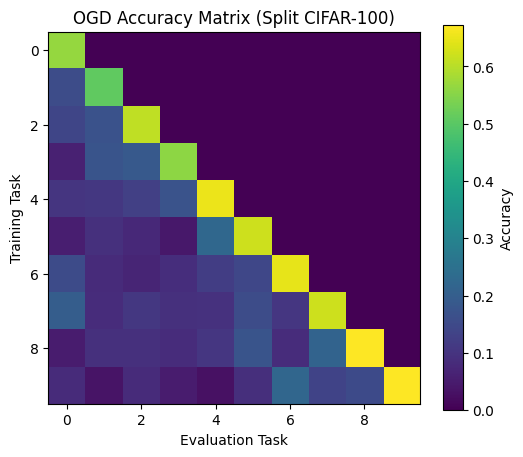

In [6]:
# ================================================
# OGD on Split CIFAR-100 (10 tasks × 10 classes)
# ================================================
# - Memory-efficient task construction
# - OGD with orthonormal gradient memory
# - Stores optimizer/criterion in OGD
# - Accuracy matrix + CL metrics + plot
# ================================================

import os
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# -----------------
# Repro & Device
# -----------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------
# Hyperparameters
# -----------------
root = "./data"
num_tasks = 10
num_classes = 100
classes_per_task = num_classes // num_tasks  # 10
batch_size = 32
num_epochs = 2
download = True

# Optimizer/loss
learning_rate = 0.001
weight_decay = 5e-4
momentum = 0.9

# OGD memory
max_mem_dirs = 1000   # cap on number of stored gradient directions (global)
dirs_per_task = 120   # target number of new directions to add per task
harvest_batches = 30  # batches to sample for memory after each task
grad_eps = 1e-6       # min norm to accept a direction

# -----------------
# Transforms
# -----------------
normalize = transforms.Normalize(mean=(0.5071, 0.4867, 0.4408),
                                 std=(0.2675, 0.2565, 0.2761))
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# -----------------
# Datasets
# -----------------
train_full = datasets.CIFAR100(root=root, train=True,  download=download, transform=train_transform)
test_full  = datasets.CIFAR100(root=root, train=False, download=download, transform=test_transform)

train_targets = np.array(train_full.targets)
test_targets  = np.array(test_full.targets)

# -----------------
# Task splits (indices & class lists)
# -----------------
task_class_lists = []
train_indices_per_task, test_indices_per_task = [], []

for t in range(num_tasks):
    cls_start = t * classes_per_task
    cls_end = cls_start + classes_per_task
    task_classes = list(range(cls_start, cls_end))
    task_class_lists.append(task_classes)

    train_idx = np.where(np.isin(train_targets, task_classes))[0].tolist()
    test_idx  = np.where(np.isin(test_targets,  task_classes))[0].tolist()

    train_indices_per_task.append(train_idx)
    test_indices_per_task.append(test_idx)

    print(f"Task {t}: classes {task_classes[0]}..{task_classes[-1]} | "
          f"train {len(train_idx)}, test {len(test_idx)}")

# -----------------
# Per-task label mapping dataset
# -----------------
class MapLabelsDataset(Dataset):
    def __init__(self, base_dataset, indices, class_map):
        self.base = base_dataset
        self.indices = indices
        self.class_map = class_map

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.base[self.indices[i]]
        return x, self.class_map[int(y)]

# -----------------
# Model
# -----------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))   # 32x16x16
        x = self.pool(F.relu(self.bn2(self.conv2(x))))   # 64x8x8
        x = self.pool(F.relu(self.bn3(self.conv3(x))))   # 128x4x4
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# -----------------
# Utils to flatten/assign grads
# -----------------
def flatten_grads(model):
    parts = []
    for p in model.parameters():
        if p.requires_grad and p.grad is not None:
            parts.append(p.grad.view(-1))
    return torch.cat(parts) if parts else torch.tensor([], device=next(model.parameters()).device)

def assign_grads_from_vector(model, grad_vec):
    offset = 0
    for p in model.parameters():
        if not p.requires_grad:
            continue
        n = p.numel()
        if p.grad is None:
            p.grad = torch.zeros_like(p)
        p.grad.copy_(grad_vec[offset:offset+n].view_as(p))
        offset += n

# -----------------
# OGD (Option 2: stores optimizer & criterion internally)
# -----------------
class OGD:
    def __init__(self, model, optimizer, criterion, device,
                 max_mem_dirs=1000, grad_eps=1e-6):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.P = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        self.memory = None   # [k, P], orthonormal rows (unit-norm)
        self.max_mem_dirs = max_mem_dirs
        self.grad_eps = grad_eps

    @torch.no_grad()
    def _project_onto_complement(self, g):
        # g: [P]
        if self.memory is None or self.memory.size(0) == 0:
            return g
        # Memory rows are orthonormal ⇒ projection is g_perp = g - M^T (M g)
        Mg = torch.mv(self.memory, g)            # [k]
        g_perp = g - torch.mv(self.memory.t(), Mg)
        return g_perp

    @torch.no_grad()
    def _add_dir_to_memory(self, g):
        # Gram-Schmidt orth against existing memory; if large enough, normalize & append
        if self.memory is not None and self.memory.size(0) > 0:
            Mg = torch.mv(self.memory, g)
            g = g - torch.mv(self.memory.t(), Mg)
        norm = torch.linalg.norm(g)
        if norm > self.grad_eps:
            g = g / norm
            if self.memory is None:
                self.memory = g.unsqueeze(0)
            else:
                if self.memory.size(0) < self.max_mem_dirs:
                    self.memory = torch.vstack([self.memory, g])
                else:
                    # Replace a random row to maintain diversity (FIFO/random policy)
                    idx = torch.randint(0, self.memory.size(0), (1,)).item()
                    self.memory[idx] = g

    def observe(self, x, y):
        """One OGD training step on a batch."""
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)

        self.optimizer.zero_grad(set_to_none=True)
        logits = self.model(x)
        loss = self.criterion(logits, y)
        loss.backward()

        # Flatten grads → project → assign → step
        g = flatten_grads(self.model).detach()
        g_perp = self._project_onto_complement(g)
        assign_grads_from_vector(self.model, g_perp)
        self.optimizer.step()
        return loss.item()

    def end_task(self, dataloader, dirs_to_add=100, harvest_batches=30):
        """Harvest gradient directions (from current task) to expand memory."""
        self.model.train()
        for p in self.model.parameters():
            p.requires_grad_(True)
        torch.set_grad_enabled(True)

        added, seen = 0, 0
        for xb, yb in dataloader:
            if seen >= harvest_batches or added >= dirs_to_add:
                break
            seen += 1

            xb, yb = xb.to(self.device), yb.to(self.device)
            self.model.zero_grad(set_to_none=True)
            logits = self.model(xb)
            loss = self.criterion(logits, yb)
            loss.backward()

            g = flatten_grads(self.model).detach()
            self._add_dir_to_memory(g)
            added += 1

        print(f"[OGD] Harvested {added} dirs (seen {seen} batches). "
              f"Memory size: {0 if self.memory is None else self.memory.size(0)}")

# -----------------
# Eval
# -----------------
@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return correct / max(1, total)

# -----------------
# Init model/optimizer/criterion/OGD
# -----------------
model = SimpleCNN(num_classes=classes_per_task).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

ogd = OGD(model, optimizer, criterion, device,
          max_mem_dirs=max_mem_dirs, grad_eps=grad_eps)

# -----------------
# Train across tasks
# -----------------
accuracy_matrix = np.zeros((num_tasks, num_tasks), dtype=np.float32)

loader_kwargs = dict(num_workers=2, pin_memory=True) if device.type == "cuda" else dict(num_workers=0)

for t in range(num_tasks):
    # Datasets & loaders for task t (labels remapped to 0..9)
    class_map = {orig: i for i, orig in enumerate(task_class_lists[t])}
    train_ds_t = MapLabelsDataset(train_full, train_indices_per_task[t], class_map)
    test_ds_t  = MapLabelsDataset(test_full,  test_indices_per_task[t],  class_map)

    train_loader = DataLoader(train_ds_t, batch_size=batch_size, shuffle=True,  **loader_kwargs)
    test_loader  = DataLoader(test_ds_t,  batch_size=batch_size, shuffle=False, **loader_kwargs)

    print(f"\n=== Task {t+1}/{num_tasks} | classes {task_class_lists[t][0]}..{task_class_lists[t][-1]} ===")
    for epoch in range(1, num_epochs + 1):
        running = 0.0
        for xb, yb in tqdm(train_loader, desc=f"Task {t+1} Epoch {epoch}"):
            running += ogd.observe(xb, yb)
        print(f"Epoch {epoch}: loss={running/len(train_loader):.4f}")

    # Evaluate on all seen tasks so far
    for j in range(t + 1):
        class_map_eval = {orig: i for i, orig in enumerate(task_class_lists[j])}
        test_ds_eval = MapLabelsDataset(test_full, test_indices_per_task[j], class_map_eval)
        test_loader_eval = DataLoader(test_ds_eval, batch_size=batch_size, shuffle=False, **loader_kwargs)
        acc = evaluate(ogd.model, test_loader_eval, device)
        accuracy_matrix[t, j] = acc
        print(f"Accuracy on Task {j+1}: {acc:.3f}")

    # Grow OGD memory from current task data
    ogd.end_task(train_loader, dirs_to_add=dirs_per_task, harvest_batches=harvest_batches)


# Compute Continual Learning Metrics
# Average Accuracy (ACC)
ACC = accuracy_matrix[-1].mean()  # Final row averaged across tasks

# Average Forgetting (F)
F = np.mean([
    np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j]
    for j in range(num_tasks-1)
])

# Backward Transfer (BWT)
BWT = np.mean([
    accuracy_matrix[-1, j] - accuracy_matrix[j, j]
    for j in range(num_tasks-1)
])

# Forward Transfer (FWT)
# Measures how much previous tasks helped the next task before it was trained
FWT = np.mean([
    accuracy_matrix[i, i+1]
    for i in range(num_tasks-1)
])

# Memory Usage (in MB)
num_params = sum(p.numel() for p in ogd.model.parameters())
dirs_count = 0 if ogd.memory is None else ogd.memory.size(0)
mem_usage = dirs_count * num_params * 4 / (1024**2)  # 4 bytes per float32

# Computation Cost (approximate as #dirs, since each step projects on memory)
comp_cost = dirs_count

# Plasticity-Stability Measure (PSM) - Normalized 0 to 1

# Define components
stability = 1 - F                 # High if forgetting is low
plasticity = max(FWT, 0)          # High if positive forward transfer

alpha = 0.5                       # Balance between stability and plasticity
PSM = alpha * stability + (1 - alpha) * plasticity

# Print Metrics
print("=== Continual Learning Metrics ===")
print(f"Average Accuracy (ACC):       {ACC:.4f}")
print(f"Forgetting (F):              {F:.4f}")
print(f"Backward Transfer (BWT):     {BWT:.4f}")
print(f"Forward Transfer (FWT):      {FWT:.4f}")
print(f"Memory Usage:                {mem_usage:.2f} MB")
print(f"Computation Cost:            {comp_cost} projections/batch")
print(f"Plasticity-Stability Measure (PSM): {PSM:.4f} (0-1 normalized)")

print("=== Metrics (Split CIFAR-100) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('OGD Accuracy Matrix (Split CIFAR-100)')
plt.show()

Device: cuda

=== Task 1/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 1 Epoch 1: 100%|██████████| 2084/2084 [00:16<00:00, 124.63it/s]


Epoch 1: loss=4.3247


Task 1 Epoch 2: 100%|██████████| 2084/2084 [00:15<00:00, 132.25it/s]


Epoch 2: loss=3.9347
Files already downloaded and verified
Accuracy on Task 1: 0.110
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 30

=== Task 2/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 2 Epoch 1: 100%|██████████| 2084/2084 [00:17<00:00, 118.73it/s]


Epoch 1: loss=3.9525


Task 2 Epoch 2: 100%|██████████| 2084/2084 [00:18<00:00, 115.09it/s]


Epoch 2: loss=3.7521
Files already downloaded and verified
Accuracy on Task 1: 0.058
Files already downloaded and verified
Accuracy on Task 2: 0.138
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 60

=== Task 3/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 3 Epoch 1: 100%|██████████| 2084/2084 [00:16<00:00, 129.07it/s]


Epoch 1: loss=3.8712


Task 3 Epoch 2: 100%|██████████| 2084/2084 [00:17<00:00, 122.57it/s]


Epoch 2: loss=3.6755
Files already downloaded and verified
Accuracy on Task 1: 0.039
Files already downloaded and verified
Accuracy on Task 2: 0.072
Files already downloaded and verified
Accuracy on Task 3: 0.150
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 90

=== Task 4/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 4 Epoch 1: 100%|██████████| 2084/2084 [00:17<00:00, 116.83it/s]


Epoch 1: loss=3.8202


Task 4 Epoch 2: 100%|██████████| 2084/2084 [00:17<00:00, 118.43it/s]


Epoch 2: loss=3.6334
Files already downloaded and verified
Accuracy on Task 1: 0.032
Files already downloaded and verified
Accuracy on Task 2: 0.043
Files already downloaded and verified
Accuracy on Task 3: 0.093
Files already downloaded and verified
Accuracy on Task 4: 0.160
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 120

=== Task 5/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 5 Epoch 1: 100%|██████████| 2084/2084 [00:18<00:00, 111.91it/s]


Epoch 1: loss=3.7899


Task 5 Epoch 2: 100%|██████████| 2084/2084 [00:18<00:00, 110.27it/s]


Epoch 2: loss=3.5924
Files already downloaded and verified
Accuracy on Task 1: 0.027
Files already downloaded and verified
Accuracy on Task 2: 0.030
Files already downloaded and verified
Accuracy on Task 3: 0.050
Files already downloaded and verified
Accuracy on Task 4: 0.077
Files already downloaded and verified
Accuracy on Task 5: 0.161
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 150

=== Task 6/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 6 Epoch 1: 100%|██████████| 2084/2084 [00:18<00:00, 112.62it/s]


Epoch 1: loss=3.7994


Task 6 Epoch 2: 100%|██████████| 2084/2084 [00:18<00:00, 111.64it/s]


Epoch 2: loss=3.5860
Files already downloaded and verified
Accuracy on Task 1: 0.025
Files already downloaded and verified
Accuracy on Task 2: 0.024
Files already downloaded and verified
Accuracy on Task 3: 0.034
Files already downloaded and verified
Accuracy on Task 4: 0.039
Files already downloaded and verified
Accuracy on Task 5: 0.088
Files already downloaded and verified
Accuracy on Task 6: 0.160
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 180

=== Task 7/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 7 Epoch 1: 100%|██████████| 2084/2084 [00:17<00:00, 116.99it/s]


Epoch 1: loss=3.7802


Task 7 Epoch 2: 100%|██████████| 2084/2084 [00:18<00:00, 111.57it/s]


Epoch 2: loss=3.5576
Files already downloaded and verified
Accuracy on Task 1: 0.029
Files already downloaded and verified
Accuracy on Task 2: 0.025
Files already downloaded and verified
Accuracy on Task 3: 0.034
Files already downloaded and verified
Accuracy on Task 4: 0.036
Files already downloaded and verified
Accuracy on Task 5: 0.043
Files already downloaded and verified
Accuracy on Task 6: 0.086
Files already downloaded and verified
Accuracy on Task 7: 0.172
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 210

=== Task 8/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 8 Epoch 1: 100%|██████████| 2084/2084 [00:18<00:00, 111.36it/s]


Epoch 1: loss=3.7676


Task 8 Epoch 2: 100%|██████████| 2084/2084 [00:18<00:00, 109.97it/s]


Epoch 2: loss=3.5461
Files already downloaded and verified
Accuracy on Task 1: 0.028
Files already downloaded and verified
Accuracy on Task 2: 0.024
Files already downloaded and verified
Accuracy on Task 3: 0.030
Files already downloaded and verified
Accuracy on Task 4: 0.033
Files already downloaded and verified
Accuracy on Task 5: 0.040
Files already downloaded and verified
Accuracy on Task 6: 0.048
Files already downloaded and verified
Accuracy on Task 7: 0.098
Files already downloaded and verified
Accuracy on Task 8: 0.173
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 240

=== Task 9/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 9 Epoch 1: 100%|██████████| 2084/2084 [00:18<00:00, 112.14it/s]


Epoch 1: loss=3.7384


Task 9 Epoch 2: 100%|██████████| 2084/2084 [00:18<00:00, 114.69it/s]


Epoch 2: loss=3.5283
Files already downloaded and verified
Accuracy on Task 1: 0.028
Files already downloaded and verified
Accuracy on Task 2: 0.026
Files already downloaded and verified
Accuracy on Task 3: 0.028
Files already downloaded and verified
Accuracy on Task 4: 0.030
Files already downloaded and verified
Accuracy on Task 5: 0.034
Files already downloaded and verified
Accuracy on Task 6: 0.034
Files already downloaded and verified
Accuracy on Task 7: 0.054
Files already downloaded and verified
Accuracy on Task 8: 0.099
Files already downloaded and verified
Accuracy on Task 9: 0.167
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 270

=== Task 10/10 (unique pixel permutation) ===
Files already downloaded and verified
Files already downloaded and verified


Task 10 Epoch 1: 100%|██████████| 2084/2084 [00:19<00:00, 105.69it/s]


Epoch 1: loss=3.7127


Task 10 Epoch 2: 100%|██████████| 2084/2084 [00:19<00:00, 105.26it/s]


Epoch 2: loss=3.5077
Files already downloaded and verified
Accuracy on Task 1: 0.025
Files already downloaded and verified
Accuracy on Task 2: 0.026
Files already downloaded and verified
Accuracy on Task 3: 0.026
Files already downloaded and verified
Accuracy on Task 4: 0.027
Files already downloaded and verified
Accuracy on Task 5: 0.033
Files already downloaded and verified
Accuracy on Task 6: 0.030
Files already downloaded and verified
Accuracy on Task 7: 0.047
Files already downloaded and verified
Accuracy on Task 8: 0.061
Files already downloaded and verified
Accuracy on Task 9: 0.110
Files already downloaded and verified
Accuracy on Task 10: 0.176
[OGD] Harvested 30 dirs (seen 30 batches). Memory size: 300

=== Metrics (Permuted CIFAR-100, CNN, OGD) ===
ACC=0.0562, F=0.1117, BWT=-0.1117, FWT=0.0000, Mem=736.93 MB, PSM=0.4442


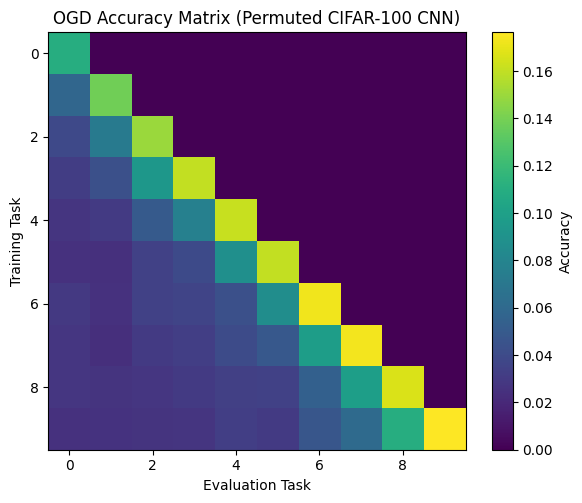

In [5]:
# ====================================================
# OGD on Permuted CIFAR-100 (num_tasks × 100 classes)
# ====================================================
# - Same CNN & OGD implementation as Split CIFAR-100
# - Each task has a unique, fixed pixel permutation
# - Full label space per task (0..99)
# ====================================================

import os
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# -----------------
# Repro & Device
# -----------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------
# Hyperparameters
# -----------------
root = "./data"
num_tasks = 10
num_classes = 100
batch_size = 24 
num_epochs = 2
download = True

# Optimizer/loss
learning_rate = 0.001
weight_decay = 5e-4
momentum = 0.9

# OGD memory
max_mem_dirs = 1000
dirs_per_task = 120
harvest_batches = 30
grad_eps = 1e-6

# -----------------
# Base normalization
# -----------------
normalize = transforms.Normalize(mean=(0.5071, 0.4867, 0.4408),
                                 std=(0.2675, 0.2565, 0.2761))

# -----------------
# Generate pixel permutations for each task
# -----------------
img_size = 32
num_pixels = img_size * img_size * 3
permutations = [torch.randperm(num_pixels) for _ in range(num_tasks)]

class PermutePixels:
    """Transform to permute pixels using a fixed order."""
    def __init__(self, perm):
        self.perm = perm

    def __call__(self, img):
        # img: Tensor [C,H,W]
        c, h, w = img.size()
        flat = img.view(-1)
        permuted = flat[self.perm]
        return permuted.view(c, h, w)

# -----------------
# Model
# -----------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# -----------------
# Utils for grads
# -----------------
def flatten_grads(model):
    parts = []
    for p in model.parameters():
        if p.requires_grad and p.grad is not None:
            parts.append(p.grad.view(-1))
    return torch.cat(parts) if parts else torch.tensor([], device=next(model.parameters()).device)

def assign_grads_from_vector(model, grad_vec):
    offset = 0
    for p in model.parameters():
        if not p.requires_grad:
            continue
        n = p.numel()
        if p.grad is None:
            p.grad = torch.zeros_like(p)
        p.grad.copy_(grad_vec[offset:offset+n].view_as(p))
        offset += n

# -----------------
# OGD (same as before)
# -----------------
class OGD:
    def __init__(self, model, optimizer, criterion, device,
                 max_mem_dirs=1000, grad_eps=1e-6):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device

        self.P = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        self.memory = None
        self.max_mem_dirs = max_mem_dirs
        self.grad_eps = grad_eps

    @torch.no_grad()
    def _project_onto_complement(self, g):
        if self.memory is None or self.memory.size(0) == 0:
            return g
        Mg = torch.mv(self.memory, g)
        g_perp = g - torch.mv(self.memory.t(), Mg)
        return g_perp

    @torch.no_grad()
    def _add_dir_to_memory(self, g):
        if self.memory is not None and self.memory.size(0) > 0:
            Mg = torch.mv(self.memory, g)
            g = g - torch.mv(self.memory.t(), Mg)
        norm = torch.linalg.norm(g)
        if norm > self.grad_eps:
            g = g / norm
            if self.memory is None:
                self.memory = g.unsqueeze(0)
            else:
                if self.memory.size(0) < self.max_mem_dirs:
                    self.memory = torch.vstack([self.memory, g])
                else:
                    idx = torch.randint(0, self.memory.size(0), (1,)).item()
                    self.memory[idx] = g

    def observe(self, x, y):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)

        self.optimizer.zero_grad(set_to_none=True)
        logits = self.model(x)
        loss = self.criterion(logits, y)
        loss.backward()

        g = flatten_grads(self.model).detach()
        g_perp = self._project_onto_complement(g)
        assign_grads_from_vector(self.model, g_perp)
        self.optimizer.step()
        return loss.item()

    def end_task(self, dataloader, dirs_to_add=100, harvest_batches=30):
        self.model.train()
        for p in self.model.parameters():
            p.requires_grad_(True)
        torch.set_grad_enabled(True)

        added, seen = 0, 0
        for xb, yb in dataloader:
            if seen >= harvest_batches or added >= dirs_to_add:
                break
            seen += 1

            xb, yb = xb.to(self.device), yb.to(self.device)
            self.model.zero_grad(set_to_none=True)
            logits = self.model(xb)
            loss = self.criterion(logits, yb)
            loss.backward()

            g = flatten_grads(self.model).detach()
            self._add_dir_to_memory(g)
            added += 1

        print(f"[OGD] Harvested {added} dirs (seen {seen} batches). "
              f"Memory size: {0 if self.memory is None else self.memory.size(0)}")

# -----------------
# Eval
# -----------------
@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return correct / max(1, total)

# -----------------
# Init
# -----------------
model = SimpleCNN(num_classes=num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
ogd = OGD(model, optimizer, criterion, device,
          max_mem_dirs=max_mem_dirs, grad_eps=grad_eps)

accuracy_matrix = np.zeros((num_tasks, num_tasks), dtype=np.float32)
loader_kwargs = dict(num_workers=2, pin_memory=True) if device.type == "cuda" else dict(num_workers=0)

# -----------------
# Train across permuted tasks
# -----------------
for t in range(num_tasks):
    print(f"\n=== Task {t+1}/{num_tasks} (unique pixel permutation) ===")
    
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        PermutePixels(permutations[t]),
        normalize
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        PermutePixels(permutations[t]),
        normalize
    ])

    train_ds_t = datasets.CIFAR100(root=root, train=True, download=download, transform=train_transform)
    test_ds_t  = datasets.CIFAR100(root=root, train=False, download=download, transform=test_transform)

    train_loader = DataLoader(train_ds_t, batch_size=batch_size, shuffle=True, **loader_kwargs)
    test_loader  = DataLoader(test_ds_t, batch_size=batch_size, shuffle=False, **loader_kwargs)

    for epoch in range(1, num_epochs + 1):
        running = 0.0
        for xb, yb in tqdm(train_loader, desc=f"Task {t+1} Epoch {epoch}"):
            running += ogd.observe(xb, yb)
        print(f"Epoch {epoch}: loss={running/len(train_loader):.4f}")

    # Evaluate on all seen tasks
    for j in range(t + 1):
        eval_transform = transforms.Compose([
            transforms.ToTensor(),
            PermutePixels(permutations[j]),
            normalize
        ])
        eval_ds = datasets.CIFAR100(root=root, train=False, download=download, transform=eval_transform)
        eval_loader = DataLoader(eval_ds, batch_size=batch_size, shuffle=False, **loader_kwargs)
        acc = evaluate(ogd.model, eval_loader, device)
        accuracy_matrix[t, j] = acc
        print(f"Accuracy on Task {j+1}: {acc:.3f}")

    ogd.end_task(train_loader, dirs_to_add=dirs_per_task, harvest_batches=harvest_batches)

# -----------------
# Metrics
# -----------------
ACC = accuracy_matrix[-1, :].mean()
if num_tasks > 1:
    F   = np.mean([np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j] for j in range(num_tasks-1)])
    BWT = np.mean([accuracy_matrix[-1, j] - accuracy_matrix[j, j] for j in range(num_tasks-1)])
    FWT = np.mean([accuracy_matrix[i, i+1] for i in range(num_tasks-1)])
else:
    F = BWT = FWT = 0.0

P = sum(p.numel() for p in ogd.model.parameters() if p.requires_grad)
k = 0 if ogd.memory is None else ogd.memory.size(0)
mem_usage_mb = (k * P * 4) / (1024**2)
PSM = 0.5 * (1 - F) + 0.5 * max(FWT, 0)

print("\n=== Metrics (Permuted CIFAR-100, CNN, OGD) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage_mb:.2f} MB, PSM={PSM:.4f}")

# -----------------
# Plot
# -----------------
plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('OGD Accuracy Matrix (Permuted CIFAR-100 CNN)')
plt.tight_layout()
plt.show()

Files already downloaded and verified
Files already downloaded and verified
Task 0: classes 0-1, train=10000, test=2000
Task 1: classes 2-3, train=10000, test=2000
Task 2: classes 4-5, train=10000, test=2000
Task 3: classes 6-7, train=10000, test=2000
Task 4: classes 8-9, train=10000, test=2000
Prepared 5 tasks (Split CIFAR-10)

=== Training Task 1 ===


100%|██████████| 313/313 [00:01<00:00, 197.99it/s]


Epoch 1, Loss=0.3035


100%|██████████| 313/313 [00:01<00:00, 194.58it/s]


Epoch 2, Loss=0.1691
Accuracy on Task 1: 0.941

=== Training Task 2 ===


100%|██████████| 313/313 [00:01<00:00, 200.19it/s]


Epoch 1, Loss=0.4776


100%|██████████| 313/313 [00:01<00:00, 189.69it/s]


Epoch 2, Loss=0.3785
Accuracy on Task 1: 0.749
Accuracy on Task 2: 0.828

=== Training Task 3 ===


100%|██████████| 313/313 [00:01<00:00, 196.83it/s]


Epoch 1, Loss=0.3822


100%|██████████| 313/313 [00:01<00:00, 208.92it/s]


Epoch 2, Loss=0.2782
Accuracy on Task 1: 0.734
Accuracy on Task 2: 0.700
Accuracy on Task 3: 0.882

=== Training Task 4 ===


100%|██████████| 313/313 [00:01<00:00, 198.13it/s]


Epoch 1, Loss=0.2448


100%|██████████| 313/313 [00:01<00:00, 242.90it/s]


Epoch 2, Loss=0.1074
Accuracy on Task 1: 0.491
Accuracy on Task 2: 0.532
Accuracy on Task 3: 0.643
Accuracy on Task 4: 0.959

=== Training Task 5 ===


100%|██████████| 313/313 [00:01<00:00, 189.82it/s]


Epoch 1, Loss=0.2641


100%|██████████| 313/313 [00:01<00:00, 200.72it/s]


Epoch 2, Loss=0.1635
Accuracy on Task 1: 0.793
Accuracy on Task 2: 0.580
Accuracy on Task 3: 0.516
Accuracy on Task 4: 0.580
Accuracy on Task 5: 0.930
=== Metrics (Split CIFAR-10 CNN OGD) ===
ACC=0.6800, F=0.2851, BWT=-0.2851, FWT=0.0000, Mem=20.38MB, PSM=0.3574


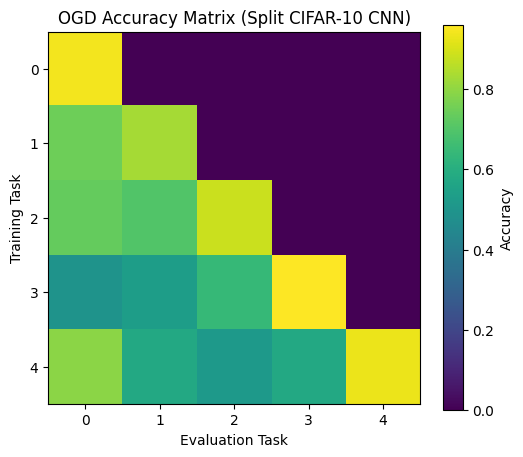

In [3]:
# === Cell: prepare CIFAR-10 tasks for OGD (split) with CNN ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Hyperparameters ===
root = './data'
num_tasks = 5            
num_classes = 10         
classes_per_task = num_classes // num_tasks   # = 2
batch_size = 32
download = True
num_epochs = 2
learning_rate = 0.001
mem_size = 200   # how many gradient directions to store per task

# CIFAR-10 mean/std for normalization
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)

# === Transforms ===
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()

# === Load datasets ===
train_ds = datasets.CIFAR10(root=root, train=True, download=download, transform=train_transform)
test_ds = datasets.CIFAR10(root=root, train=False, download=download, transform=test_transform)

# === Helper: extract subset tensors for a given set of class IDs ===
def extract_subset_tensors(dataset, class_list):
    targets = np.array(dataset.targets)
    mask = np.isin(targets, class_list)
    indices = np.nonzero(mask)[0].tolist()
    imgs, labs = [], []
    for i in indices:
        img, lbl = dataset[i]
        imgs.append(img)
        labs.append(lbl)
    return torch.stack(imgs), torch.tensor(labs, dtype=torch.long)

# === Build tasks ===
train_tasks, test_tasks = [], []
for t in range(num_tasks):
    cls_start = t * classes_per_task
    cls_end = cls_start + classes_per_task
    task_classes = list(range(cls_start, cls_end))

    x_train, y_train = extract_subset_tensors(train_ds, task_classes)
    x_test, y_test = extract_subset_tensors(test_ds, task_classes)

    # Normalize
    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std

    # Map labels to 0..(classes_per_task-1)
    class_map = {orig: i for i, orig in enumerate(task_classes)}
    y_train_mapped = torch.tensor([class_map[int(v)] for v in y_train])
    y_test_mapped = torch.tensor([class_map[int(v)] for v in y_test])

    train_tasks.append(TensorDataset(x_train, y_train_mapped))
    test_tasks.append(TensorDataset(x_test, y_test_mapped))

    print(f"Task {t}: classes {task_classes[0]}-{task_classes[-1]}, train={len(x_train)}, test={len(x_test)}")

print(f"Prepared {len(train_tasks)} tasks (Split CIFAR-10)")

# === CNN model ===
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):   # 2 classes per task
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x16x16
        x = self.pool(F.relu(self.conv2(x)))  # 64x8x8
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# === OGD class ===
class OGD:
    def __init__(self, model, lr=0.001, device="cpu", mem_size=200):
        self.model = model.to(device)
        self.opt = optim.Adam(self.model.parameters(), lr=lr)
        self.device = device
        self.S = []  # stored gradient directions
        self.mem_size = mem_size

    def project(self, grad_vec):
        if not self.S:
            return grad_vec
        proj_grad = grad_vec.clone()
        for g in self.S:
            proj_grad -= (proj_grad @ g) * g
        return proj_grad

    def observe(self, x, y):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.opt.zero_grad()
        loss = F.cross_entropy(self.model(x), y)
        loss.backward()

        grad_vec = torch.cat([p.grad.view(-1) for p in self.model.parameters()])
        grad_proj = self.project(grad_vec)
        idx = 0
        for p in self.model.parameters():
            numel = p.numel()
            p.grad.copy_(grad_proj[idx:idx+numel].view_as(p))
            idx += numel

        self.opt.step()
        return loss.item()

    def end_task(self, dataloader):
        self.model.eval()
        grads = []
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.opt.zero_grad()
            loss = F.cross_entropy(self.model(x), y)
            loss.backward()
            g = torch.cat([p.grad.view(-1) for p in self.model.parameters()])
            grads.append(g / g.norm())
            if len(grads) >= self.mem_size:
                break
        if grads:
            mean_g = torch.stack(grads).mean(0)
            mean_g /= mean_g.norm()
            self.S.append(mean_g)
            if len(self.S) > self.mem_size:
                self.S.pop(0)

# === Training loop with OGD ===
ogd = OGD(SimpleCNN(num_classes=classes_per_task), lr=learning_rate, device=device, mem_size=mem_size)
accuracy_matrix = np.zeros((num_tasks, num_tasks))

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            epoch_loss += ogd.observe(x, y)
        print(f"Epoch {epoch+1}, Loss={epoch_loss/len(train_loader):.4f}")

    # Evaluate on all seen tasks
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False)
        acc = evaluate_task(ogd.model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

    ogd.end_task(train_loader)

# === Metrics ===
ACC = accuracy_matrix[-1].mean()
F = np.mean([np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
BWT = np.mean([accuracy_matrix[-1, j] - accuracy_matrix[j, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
FWT = np.mean([accuracy_matrix[i, i+1] for i in range(num_tasks-1)]) if num_tasks>1 else 0.0
num_params = sum(p.numel() for p in ogd.model.parameters())
mem_usage = len(ogd.S) * num_params * 4 / (1024**2)
PSM = 0.5*(1-F) + 0.5*max(FWT,0)

print("=== Metrics (Split CIFAR-10 CNN OGD) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('OGD Accuracy Matrix (Split CIFAR-10 CNN)')
plt.show()